# Create "intermediate" datasets: CIFAR-10 and CIFAR-100

This notebook creates the "intermediate" datasets for CIFAR-10 and CIFAR-100. This means training a CNN on a dataset, removing the fully-connected layers and producing the (flattened) output from the last convolutional layers. This output is then referred to as the intermediate dataset and saved for future reuse.

The intermediate datasets from this notebook are created imported images. In this case, either CIFAR-10 or CIFAR-100 is used.

<br>

Rui Filipe Martins Monteiro (R20170796) | MSc in Data Science and Advanced Analytics

In [2]:
!pip install ann_visualizer

  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=db37acacc253ae5832597fe69cf6b499e6f5b761d35ef54b23c83ad217091d4b
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


In [3]:
# Imports
import json
import pandas as pd
import numpy as np

import os
import datetime
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.initializers import glorot_normal, RandomNormal, Zeros

import math
from tensorflow.keras.datasets import cifar10, cifar100
from scipy.cluster.vq import whiten

import glob

from tensorflow.keras.applications import InceptionV3, Xception, InceptionResNetV2
from tensorflow.keras import Model

from ann_visualizer.visualize import ann_viz

from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings("ignore")

## Functions

In [4]:
def show_image_classes(images, classes, prefix, suffix=""):
    """Save input images in folder structure and output them

    Parameters
    ----------
    images : array, e.g. numpy array
        images to show

    classes : list
        [not used]

    prefix : string
        prefix to add to output name

    suffix : string
        suffix to add to output name
    """
    for cl in np.unique(y_train):
        for ind, el in enumerate(y_train):
            if el == cl:
                class_pos = ind
                break
        plt.figure()
        plt.imshow(np.uint8(x_train[class_pos]))
        path = "sample_images/" + prefix + "/"
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(path + input_path.split("/")[1].split("_")[0] + "_" + str(cl) + "_sample_image_" + suffix)

In [5]:
def normalize_production(x, cifar_version):
    """This function is used to normalize instances in production according to saved training set statistics
    (from https://github.com/geifmany/cifar-vgg)

    Parameters
    ----------
    X_train : array, e.g., numpy array
        training data set

    X_test : array, e.g., numpy array
        test data set
    
    cifar_version : string
        the version of CIFAR that's being used - either 'cifar10' or 'cifar100'

    Returns: normalized training set and test set according to preset constants.
    """
    # These values are produced during first training and are general for the standard CIFAR training set normalization
    if cifar_version == 'cifar10':
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    if cifar_version == 'cifar100':
        mean = 121.936
        std = 68.389
        return (x-mean)/(std+1e-7)

In [6]:
def normalize_data(x_train, x_test, cifar_version):
    """Format the input data by normalizing it

    Parameters
    ----------
    x_train : array, e.g., numpy array
        training data to transform
        
    x_test : array, e.g., numpy array
        test data to transform
        
    cifar_version : string
        the version of CIFAR that's being used - either 'cifar10' or 'cifar100'
    """
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = normalize_production(x_train, cifar_version)
    x_test = normalize_production(x_test, cifar_version)
    
    return x_train, x_test

In [7]:
def create_MLP_1(input_shape):
    """Create multi-layer perceptron with predefined structure.
    This CNN was manually designed by: Jonathan Janke (from https://github.com/novajon/classy-conv-features)

    Parameters
    ----------
    input_shape : tuple
        shape of the input data
    """
    model = Sequential()
    model.add(Conv2D(128, (3, 3), padding='same',
            input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [50]:
def cut_model(input_model):
    """Removes fully-connected layer from the end of a CNN model

    Parameters
    ----------
    input_model : Model
        model to cut
    """
    dense_layer_count = 0
    count = False
    model_length = len(input_model.layers)
    output_model = Sequential()
    output_config = []

    for index in range(model_length):
        if count == True:
            output_config.append(layer.get_config())
            input_model.pop()
        else:
            layer = input_model.layers[index]
        if layer.name.startswith('flatten'):
            count = True
            output_model.add(InputLayer(input_shape=layer.output_shape))          
    # return output_model

In [52]:
def create_output_files(x_train, x_test, y_train, y_test, prefix, suffix = ""):
    """Create the output files to save intermediate datasets for further use

    Parameters
    ----------
    x_train : array, e.g., numpy array
        training input data

    x_test : array, e.g., numpy array
        testing input data

    y_train : list
        training target data

    y_test : list
        test target data

    prefix : string
        prefix to add to output file name

    suffix : string
        suffix to add to output file name
    """
    for i, model in enumerate(models):
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        pred_train_with_target = np.array([np.array([preds, y_train[i]]) for i, preds in enumerate(pred_train)])
        pred_test_with_target = np.array([np.array([preds, y_test[i]]) for i, preds in enumerate(pred_test)])
        path = input_path + "intermediate/" + prefix + "/" + model_names[i]
        
        if not os.path.exists(path):
            os.makedirs(path)
            
        np.save(path + "/train" + suffix, pred_train_with_target)
        np.save(path + "/test" + suffix, pred_test_with_target)

In [57]:
def plot_model_stats(hist):
    """Plot model statistics after the learning procedure, e.g. accuracy development over time (epochs)

    Parameters
    ----------
    hist : Histogram
        model statistics to plot
    """
    # Summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Data Exploration

In [8]:
# Load dataset
cifar_version = 'cifar10'
input_path = "data/cifar10_filtered/"
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [9]:
# cifar_version = 'cifar100'
# input_path = "data/cifar100_filtered/"
# (x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [10]:
num_classes = len(np.unique(y_train))
num_classes

10

In [11]:
treat_data = "normalize"

In [12]:
# Produce a timestamp to attach to future outputs
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")

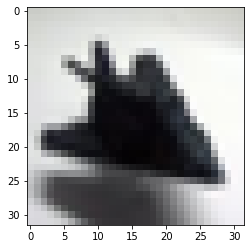

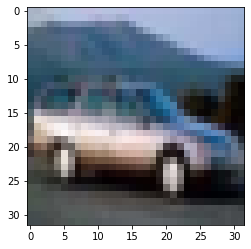

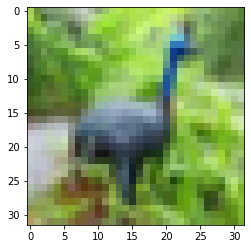

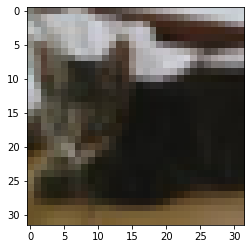

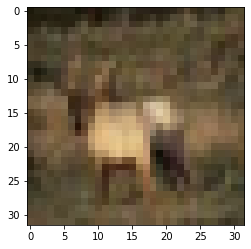

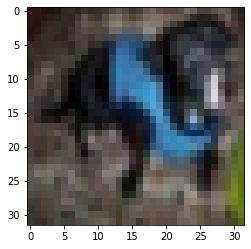

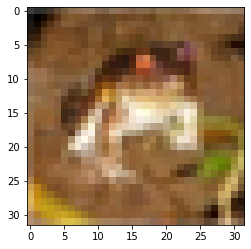

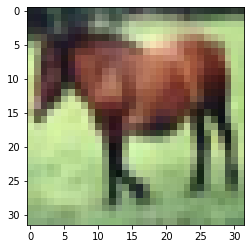

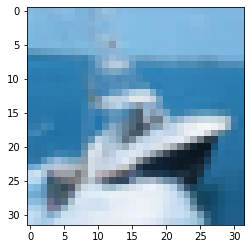

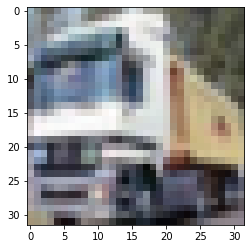

In [13]:
# Show the images to get a visual understanding of the classes
show_image_classes(x_train, y_train, prefix, "raw")

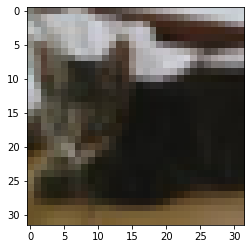

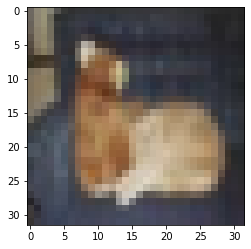

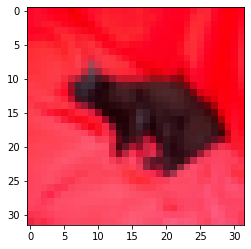

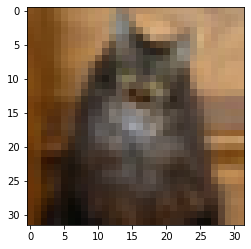

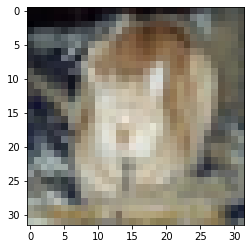

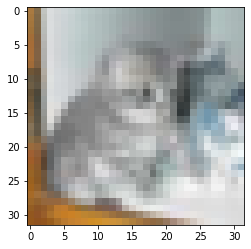

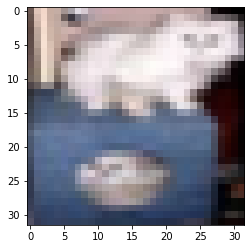

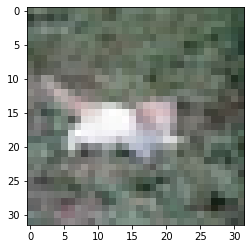

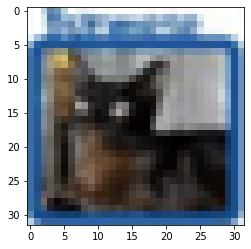

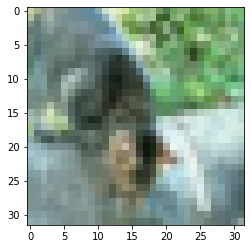

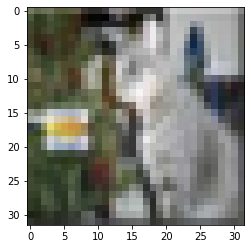

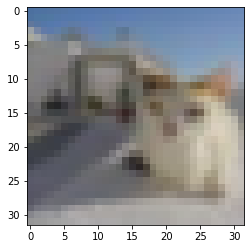

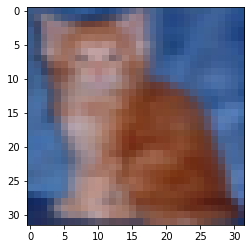

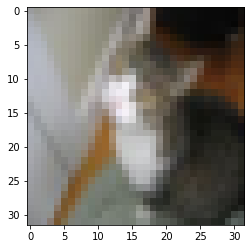

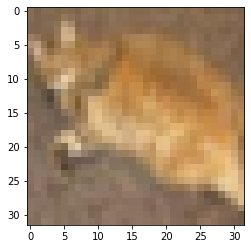

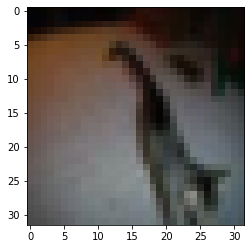

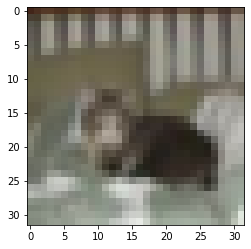

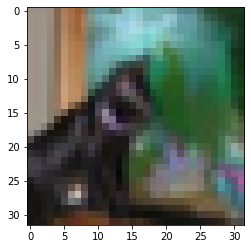

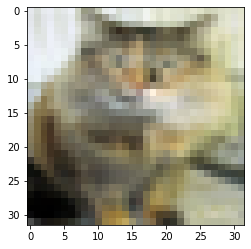

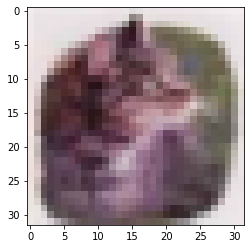

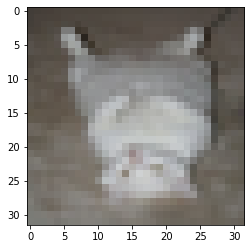

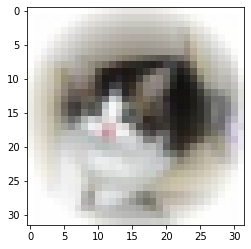

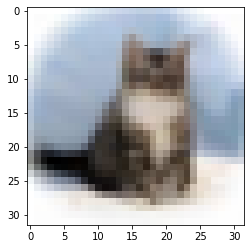

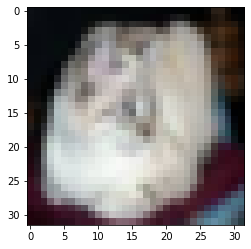

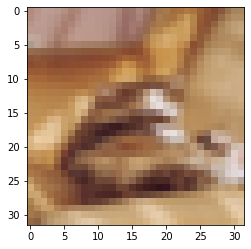

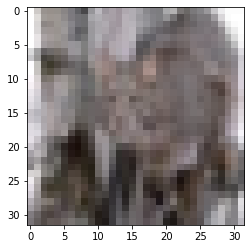

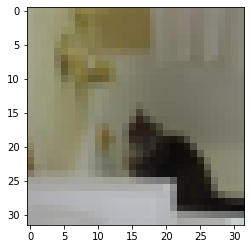

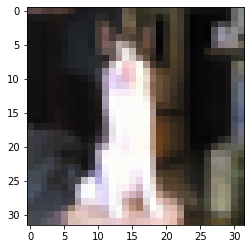

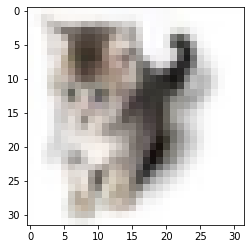

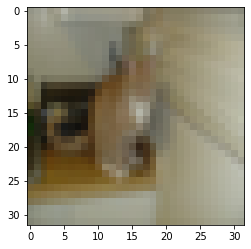

In [14]:
# Check the first "n_images" images of class number "class_n"
n_images = 30
class_n = 3

class_n_pos = [ind for ind, el in enumerate(y_train) if el == class_n]

for img in class_n_pos[:n_images]:
    plt.figure()
    plt.imshow(np.uint8(x_train[img]))

## Data Transformation

In [15]:
# Preprocess data through normalization
# Normalisation of data according to predefined normalize_data method
if treat_data == "normalize":
    x_train, x_test = normalize_data(x_train, x_test, cifar_version=cifar_version)

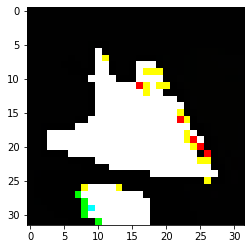

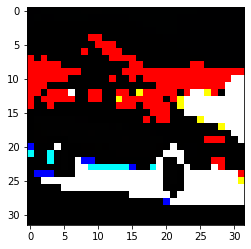

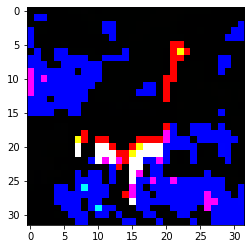

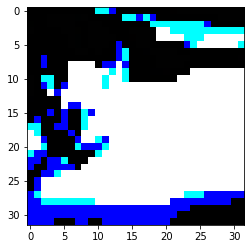

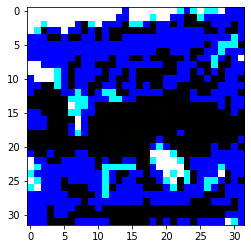

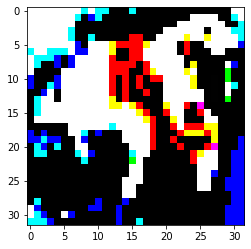

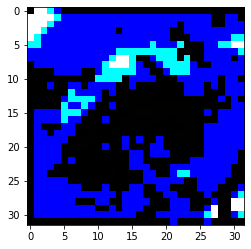

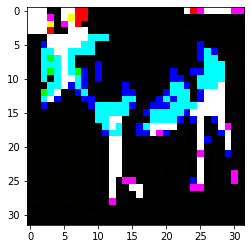

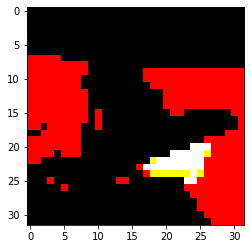

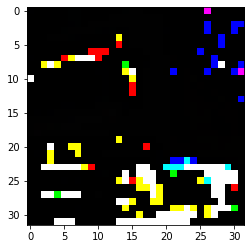

In [16]:
# Show normalised data
if treat_data == "normalize": 
    show_image_classes(x_train, y_train, prefix, "normalised")

In [17]:
# Make target values categorical (one-hot encoded)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

## Neural Network Training

In [18]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, 
                                                       samplewise_center=False, 
                                                       featurewise_std_normalization=False, 
                                                       samplewise_std_normalization=False, 
                                                       zca_whitening=False, 
                                                       zca_epsilon=1e-06, 
                                                       rotation_range=0.0, 
                                                       width_shift_range=0.0, 
                                                       height_shift_range=0.0, 
                                                       brightness_range=None, 
                                                       shear_range=0.0, 
                                                       zoom_range=0.0, 
                                                       channel_shift_range=0.0, 
                                                       fill_mode='nearest', 
                                                       cval=0.0, 
                                                       horizontal_flip=False, 
                                                       vertical_flip=False, 
                                                       rescale=None, 
                                                       preprocessing_function=None, 
                                                       data_format=None, 
                                                       validation_split=0.0)

In [19]:
# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

In [20]:
models = []
model_names = []
input_shape = x_train[0].shape
batch_size = 100
epochs = 80

In [21]:
# Create neural network models
models.append(create_MLP_1(input_shape))
model_names.append("MLP_Input_1")

In [22]:
history = []
lr = 0.0001

for model in models:
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(lr=lr),
                  metrics=['accuracy'])

In [23]:
path = os.getcwd() + '/models/h5files/'

if not os.path.exists(path):
    os.makedirs(path)

# Fit neural network models to training data
for model_ind, model in enumerate(models):  
    history.append(
      model.fit_generator(
          datagen.flow(x_train, y_train_categorical, batch_size=batch_size),
          steps_per_epoch=len(x_train)/batch_size,
          epochs=epochs,
          verbose=1,
          validation_data = (x_test, y_test_categorical)))
    
    model.save_weights(path + prefix + '_' + model_names[model_ind] + ".h5")
    
    print ("Model success")

Epoch 1/80
500/500 [==============================] - 66s 112ms/step - loss: 1.5186 - accuracy: 0.4549 - val_loss: 1.1454 - val_accuracy: 0.5956
Epoch 2/80
500/500 [==============================] - 55s 109ms/step - loss: 1.1394 - accuracy: 0.6011 - val_loss: 1.0511 - val_accuracy: 0.6306
Epoch 3/80
500/500 [==============================] - 54s 109ms/step - loss: 1.0092 - accuracy: 0.6513 - val_loss: 0.9240 - val_accuracy: 0.6869
Epoch 4/80
500/500 [==============================] - 55s 111ms/step - loss: 0.9179 - accuracy: 0.6825 - val_loss: 0.8772 - val_accuracy: 0.6978
Epoch 5/80
500/500 [==============================] - 55s 110ms/step - loss: 0.8521 - accuracy: 0.7062 - val_loss: 0.8851 - val_accuracy: 0.6991
Epoch 6/80
500/500 [==============================] - 54s 108ms/step - loss: 0.7911 - accuracy: 0.7274 - val_loss: 0.7627 - val_accuracy: 0.7427
Epoch 7/80
500/500 [==============================] - 55s 110ms/step - loss: 0.7404 - accuracy: 0.7431 - val_loss: 0.7973 - val_ac

In [49]:
# Print the validation loss
for model in models:
    # The absolute error is X, thus the accuracy is 1-X
    predicted_x = model.predict(x_test)
    residuals = np.argmax(predicted_x, 1)!=np.argmax(y_test_categorical, 1)

    loss = sum(residuals)/len(residuals)
    print(f'{model_names[models.index(model)]} Validation 0/1 loss:', round(loss, 3))

MLP_Input_1 Validation 0/1 loss: 0.168


In [44]:
# Get metrics for models on unseen data
for model in models:
    score = model.evaluate(x_test, y_test_categorical, verbose=0)
    print(f'{model_names[models.index(model)]} Test loss:', round(score[0], 3))
    print(f'{model_names[models.index(model)]} Test accuracy:', round(score[1], 3))

MLP_Input_1 Test loss: 0.868
MLP_Input_1 Test accuracy: 0.832


In [43]:
# Print the number of model parameters
for model in models:
    print(f'{model_names[models.index(model)]} # of Parameters:', model.count_params())

MLP_Input_1 # of Parameters: 6684810


In [27]:
path = os.getcwd() + '/models/viz/'

if not os.path.exists(path):
    os.makedirs(path)

# Visualise the CNN model architectures
for i, model in enumerate(models):
    plot_model(model, 
               path + prefix + '_' + model_names[i] + '.png', 
               show_shapes=True)
    
    ann_viz(model, 
            filename=path + prefix + '_' + model_names[i] + '.gv', 
            title='Visualisation of ' + model_names[i])

In [51]:
# Cut the models to remove everything after the flattening layer (remove fully-connected layers)
# output_models = []
for model in models:
    cut_model(model)
    # output_models.append(out)

In [53]:
# Create output files
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")
create_output_files(x_train, 
                    x_test, 
                    y_train, 
                    y_test, 
                    prefix, 
                    suffix = "_" + treat_data)

Model: MLP_Input_1


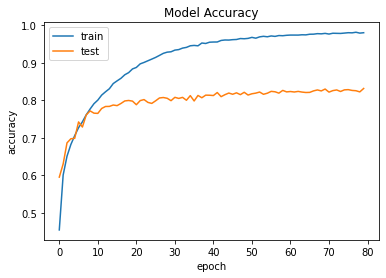

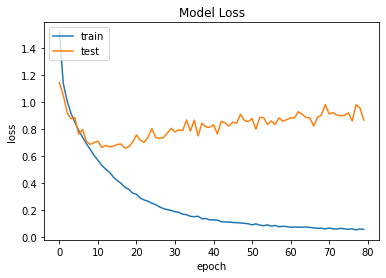

In [63]:
# Plot history of model training
index = 0
print(f'Model: {model_names[index]}')

plot_model_stats(history[index])

In [ ]:
index = 1
print(f'Model: {model_names[index]}')

plot_model_stats(history[index])

In [ ]:
index = 2
print(f'Model: {model_names[index]}')

plot_model_stats(history[index])

In [ ]:
# After this is finished: delete this notebook from GitHub -> 1_a_gp_approach_for_cv.ipynb